<a href="https://colab.research.google.com/github/Akhilps04/Project-5/blob/main/FinalEmotionPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random Forest Cross-Validation Scores: [0.88888889 0.88888889 0.77777778 0.88888889 0.625     ]
Random Forest Average Cross-Validation Score: 0.81
Regularized Random Forest Test Accuracy: 0.91


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.2652 - loss: 2.0564 - val_accuracy: 0.0000e+00 - val_loss: 1.7280
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2357 - loss: 2.1656 - val_accuracy: 0.2222 - val_loss: 1.6974
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2842 - loss: 1.9945 - val_accuracy: 0.2222 - val_loss: 1.6730
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2738 - loss: 1.6959 - val_accuracy: 0.3333 - val_loss: 1.6477
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4315 - loss: 1.7571 - val_accuracy: 0.2222 - val_loss: 1.6230
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3622 - loss: 1.5506 - val_accuracy: 0.3333 - val_loss: 1.6023
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4420 - loss: 1.4229 - val_accuracy: 0.3333 - val_loss: 1.5810
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4315 - loss: 1.5257 - val_accuracy: 0.4444 - val_loss: 1.

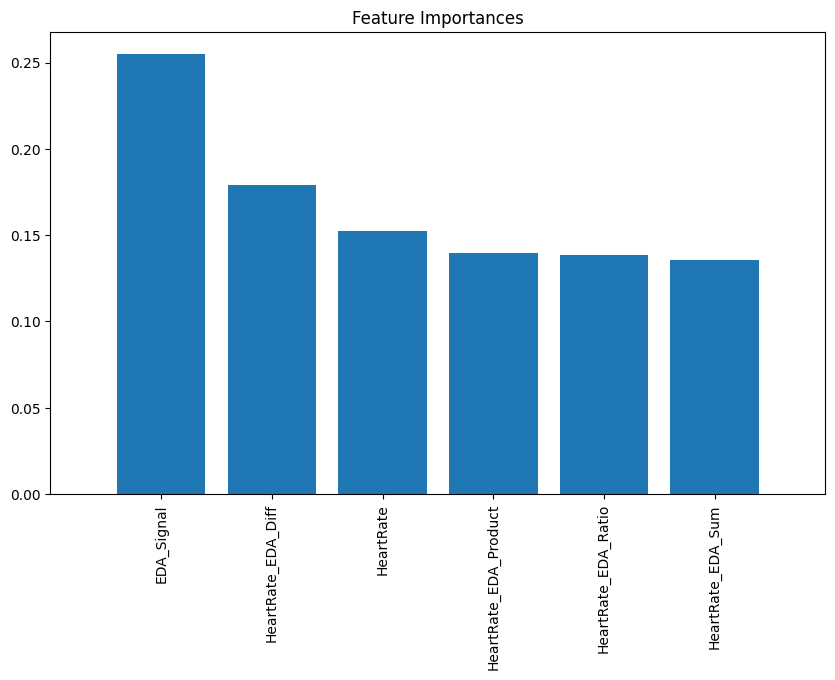

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Hybrid Model Test Accuracy: 0.91


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/augmented_psychological_emotion_dataset.csv'  # Update the path to your dataset if different
df = pd.read_csv(file_path)

# Assuming df contains 'HeartRate', 'EDA_Signal', and 'Emotion' columns

# Feature Engineering: Create new features
df['HeartRate_EDA_Ratio'] = df['HeartRate'] / df['EDA_Signal']
df['HeartRate_EDA_Diff'] = df['HeartRate'] - df['EDA_Signal']
df['HeartRate_EDA_Sum'] = df['HeartRate'] + df['EDA_Signal']
df['HeartRate_EDA_Product'] = df['HeartRate'] * df['EDA_Signal']

# Define the new feature set
X = df[['HeartRate', 'EDA_Signal', 'HeartRate_EDA_Ratio', 'HeartRate_EDA_Diff', 'HeartRate_EDA_Sum', 'HeartRate_EDA_Product']].values
y = df['Emotion'].values  # Assuming 'Emotion' is the label column

# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Step 1: Cross-Validation for Random Forest with Regularization
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f'Random Forest Cross-Validation Scores: {cv_scores}')
print(f'Random Forest Average Cross-Validation Score: {np.mean(cv_scores):.2f}')

# Train the Random Forest on the full training set and evaluate
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f'Regularized Random Forest Test Accuracy: {rf_accuracy:.2f}')

# Step 2: Train a Regularized Neural Network
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))
nn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.5))
nn_model.add(Dense(len(np.unique(y_train)), activation='softmax'))

nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

nn_preds = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, np.argmax(nn_preds, axis=1))
print(f'Regularized Neural Network Test Accuracy: {nn_accuracy:.2f}')

# Step 3: Analyze Feature Importances from the Random Forest

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(['HeartRate', 'EDA_Signal', 'HeartRate_EDA_Ratio', 'HeartRate_EDA_Diff', 'HeartRate_EDA_Sum', 'HeartRate_EDA_Product'])[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Optional: Evaluate Hybrid Model (Random Forest + Neural Network)

# Combine Predictions to Train Meta-Model
stacked_train = np.hstack((rf_model.predict_proba(X_train), nn_model.predict(X_train)))
stacked_test = np.hstack((rf_model.predict_proba(X_test), nn_model.predict(X_test)))

meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_train, y_train)

# Final Predictions
final_preds = meta_model.predict(stacked_test)
final_accuracy = accuracy_score(y_test, final_preds)
print(f'Hybrid Model Test Accuracy: {final_accuracy:.2f}')


In [3]:
import joblib
import tensorflow as tf

# Assuming rf_model, nn_model, scaler, meta_model, and label_encoder are your models and encoder

# Save Random Forest model
joblib.dump(rf_model, '/content/random_forest_model.pkl')

# Save Neural Network model
nn_model.save('/content/nn_model.h5')

# Save the scaler
joblib.dump(scaler, '/content/scaler.pkl')

# Save the meta model
joblib.dump(meta_model, '/content/meta_model.pkl')

# Save the label encoder
joblib.dump(label_encoder, '/content/label_encoder.pkl')

# Save accuracy scores
joblib.dump(final_accuracy, '/content/hybrid_accuracy.pkl')


['/content/hybrid_accuracy.pkl']

In [4]:
!pip install ipywidgets


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [5]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf

# Load the trained models and scaler
rf_model = joblib.load('/content/random_forest_model.pkl')
nn_model = tf.keras.models.load_model('/content/nn_model.h5')
scaler = joblib.load('/content/scaler.pkl')
meta_model = joblib.load('/content/meta_model.pkl')
label_encoder = joblib.load('/content/label_encoder.pkl')

# Create input widgets
heart_rate_input = widgets.FloatText(description='Heart Rate:')
eda_signal_input = widgets.FloatText(description='EDA Signal:')

# Output widgets
output_prediction = widgets.Output()
output_accuracy = widgets.Output()

# Button to trigger prediction
predict_button = widgets.Button(description='Predict Emotion')

# Define the prediction function
def predict_emotion(_):
    heart_rate = heart_rate_input.value
    eda_signal = eda_signal_input.value

    # Feature engineering
    heart_rate_eda_ratio = heart_rate / eda_signal
    heart_rate_eda_diff = heart_rate - eda_signal
    heart_rate_eda_sum = heart_rate + eda_signal
    heart_rate_eda_product = heart_rate * eda_signal

    # Create feature vector
    features = np.array([[heart_rate, eda_signal, heart_rate_eda_ratio, heart_rate_eda_diff, heart_rate_eda_sum, heart_rate_eda_product]])
    features_scaled = scaler.transform(features)

    # Get predictions from the models
    rf_pred = rf_model.predict_proba(features_scaled)
    nn_pred = nn_model.predict(features_scaled)

    # Stack predictions
    stacked_features = np.hstack((rf_pred, nn_pred))

    # Meta model prediction
    final_pred = meta_model.predict(stacked_features)
    emotion = label_encoder.inverse_transform(final_pred)[0]

    # Display the prediction
    with output_prediction:
        output_prediction.clear_output()
        print(f'Predicted Emotion: {emotion}')

    # Display the accuracy
    hybrid_accuracy = joblib.load('/content/hybrid_accuracy.pkl')  # Load the accuracy
    with output_accuracy:
        output_accuracy.clear_output()
        print(f'Model Accuracy: {hybrid_accuracy:.2f}')

# Bind the prediction function to the button
predict_button.on_click(predict_emotion)

# Display the interface
display(heart_rate_input, eda_signal_input, predict_button, output_prediction, output_accuracy)


FloatText(value=0.0, description='Heart Rate:')

FloatText(value=0.0, description='EDA Signal:')

Button(description='Predict Emotion', style=ButtonStyle())

Output()

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
